<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Library" data-toc-modified-id="Import-Library-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Library</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Drop-columns" data-toc-modified-id="Drop-columns-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Drop columns</a></span></li><li><span><a href="#Check-Missing-Value" data-toc-modified-id="Check-Missing-Value-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Check Missing Value</a></span></li></ul></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#LDA" data-toc-modified-id="LDA-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>LDA</a></span></li><li><span><a href="#Word2Vec" data-toc-modified-id="Word2Vec-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Word2Vec</a></span></li></ul></div>

## Import Library

In [1]:
import numpy as np
import pandas as pd 
import re
import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.tokenize import dict_trie, word_tokenize
import string
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
import glob
%matplotlib inline

## Load Data

In [2]:
filenames = glob.glob("final/*.csv")

In [3]:
df = pd.DataFrame()

In [4]:
for filename in filenames:
    temp = pd.read_csv(filename)
    company = filename.split("/")[1].split("_")[0]
    temp["company"] = company
    df = df.append(temp,ignore_index = True)

In [5]:
df.head()

,date,time,username,tweet,Food Delivery,Aspect,Sentiment,company
0,2020-08-23,16:30:40,pinkzaa_zaa,ใช้แต่ #LINEMAN มาตลอด\n______________________...,Yes,Company,Positive,LINEMAN
1,2020-08-23,11:29:02,roseapple110,มีคนเจอปัญหาไรเดอร์โทรหาไม่ติดตอนที่ปิดแอปทิ้ง...,Yes,Employee,Negative,LINEMAN
2,2020-08-22,18:58:12,twitneearoi,"เมนูโปรดของแมวอ้วนอย่างเรา วันนี้ขอเสนออออ ""ข้...",No,NaN,NaN,LINEMAN
3,2020-08-22,17:08:50,belloir_sj,ขั้นกว่าของการเลี้ยงหมี คือการอาบน้ำด้วย #แลคต...,No,NaN,NaN,LINEMAN
4,2020-08-22,16:23:15,ifiend_,แต่ #lineman โปรลดเข้าร่วมเยอะกว่านะ,Yes,Price,Positive,LINEMAN


## EDA

### Drop columns

In [6]:
df.drop(columns=["date","time","username"],inplace=True)

### Check Missing Value

In [7]:
np.sum(df.isnull())

tweet               0
Food Delivery       0
Aspect           3339
Sentiment        3340
company             0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
np.sum(df.isnull())

tweet            0
Food Delivery    0
Aspect           0
Sentiment        0
company          0
dtype: int64

## Preprocessing

In [11]:
## Add word in dict
custom_dict = set(thai_words())

System_ = 'ปิด ปิดร้าน ชั่วคราว ระบบ เงิน ตัด บัตร แคนเซิล ยกเลิก เป็น อาราย อะไร พัง ค้าง ล่ม เสีย สั่ง หา ไม่ได้ เด้ง รอนาน รอ ออเดอร์ พัฒนา ตัดเงิน ตัดบัตร หักเงิน แอป แอพ ปัก ปักหมุด พิกัด ใช้ ยาก ง่าย พัฒนา ไม่ตรง แผนที่ โอน เครดิต คืน รีบ แก้ ด่วน ขัดข้อง ฟื้น แก้ไข จ่ายเงิน ปัญหา ไม่เปิด ไม่เจอ แท็ก คืนเงิน ไม่พบ หา โดนระงับ ตรวจสอบ ขั้นตอน หักตังค์ เงินไม่เข้า เติมเงิน ไม่เข้า จ่ายไม่ได้ แผนที่ แบบใหม่ แบบเก่า แมพ พิกัด บัตรเครดิต บัค ฟีเจอร์ บั๊ก หมุน'
System_Aspect = System_.split(' ')

Company_ = 'คอลเซนเตอร์ คอลเซ็นเตอร์ รับผิดชอบ เบอร์ ติดต่อ สื่อสาร โทร เมล ยกเลิก เงินคืน ร้องเรียน ไม่ สนใจ เพิกเฉย รอสาย ตัดสาย บริการ ด่วน เมล โทร ศูนย์บริการ เจ้าหน้าที่ ปัญหา ชดเชย เลิกใช้ แบน บริษัท โกงเงิน บัญชี เลิกใช้ แคนเซิล ออเดอร์ ลบ องค์กร ระงับ เลิกสั่ง ประทับใจ โกง รีฟัน แนะนำ ชี้แจง แจ้ง รีวิว คอมเพลน'
Company_Aspect = Company_.split(' ')

Price_ =  'ราคา ค่าส่ง ส่วนลด โปรโมชั่น คุ้มค่า ไม่คุ้ม แพง ถูก ลด โปร บอกต่อ คุ้ม ค่าบริการ ใช้ไม่ได้ ใช้งานไม่ได้ คุณภาพ ใช้ได้ ซื้อ ขั้นต่ำ ส่งฟรี แกง บาท ส่วนต่าง ลูกค้า ใหม่ เก่า โค้ด เพิ่ม ฟรี ค่าอาหาร ค่าจอดรถ ต่ำกว่า รหัส ภาษี คำสั่งซื้อ เสียเงินเพิ่ม สังน้อย บวกเพิ่ม ขนาดเล็ก ค่าธรรมเนียม แถม เก็บ เล็ก คูปอง หมด เต็ม กด ทัน'

Price_Aspect = Price_.split(' ')

Employee_ = 'ยกเลิก รอ ช้า นาน ชั่วโมง ชม นาที ไม่ได้รับ ไม่ได้อาหาร ปัญหา รอเพิ่ม ออเดอร์ ผู้ส่ง พนักงาน คนขับ คนส่ง อบรม มารยาท คำพูด รอนาน บริการ นิสัย เละเทะ ไม่รับ สาย ส่ง ไรเดอร์ เสีย คน ติดต่อ ไม่ครบ ขาด หาย ช้า ไม่ครบ คนส่ง พนง สุภาพ นาที ไว ส่ง จัดส่ง ซ้อน ยังไม่ได้ ตั้งแต่ บอกทาง เหวี่ยง ส่งผิด ผิด ปฏิเสธ พี่ พูดเพราะ รับงาน ที่อยู่ หาย คุณ ไม่พอใจ น้อง คุ๊น ด่า เชค เช็ค ตรวจ สภาพ พ่วง ขอบคุณ โทร แซง คิว'

Employee_Aspect = Employee_.split(' ')

reviews_dict = System_Aspect+Company_Aspect+Price_Aspect+Employee_Aspect

for word in reviews_dict:
    custom_dict.add(word)

trie = dict_trie(dict_source= custom_dict)

In [12]:
type(custom_dict)

set

In [13]:
def preprocessor(text):
    
    #remove hashtag
    hashtag_removed = re.sub(r"#\w+",'', text) 
    
    #remove url
    url_removed = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', hashtag_removed)
    
    #word tokenize
    word_tokenized = pythainlp.word_tokenize(url_removed,custom_dict=trie,keep_whitespace=False,engine='pyicu')
    
    #thai filter
    word_thai = []
    for word in word_tokenized:
        if pythainlp.util.isthai(word):
            for punc in string.punctuation:
                word = word.replace(punc,'')
            if word != '':
                word_thai.append(word)
                
    #check vocab
    check_vocab = []
    for word in word_thai:
        if word in custom_dict:
            check_vocab.append(word)
                
    #remove stopword
    removed_stopword = []
    for word in check_vocab:
        if word not in pythainlp.corpus.common.thai_stopwords():
            removed_stopword.append(word)
    
    
    #remove name of company
    remove_company_name = []
    for word in removed_stopword:
        if word not in ['ฟู้ดแพนด้า','แกรป','แกป','ไลน์แมน','แพนด้า']:
            remove_company_name.append(word)
                
    return remove_company_name

In [14]:
df['preprocessed'] = df['tweet'].map(preprocessor)

In [15]:
df.head()

,tweet,Food Delivery,Aspect,Sentiment,company,preprocessed
0,ใช้แต่ #LINEMAN มาตลอด\n______________________...,Yes,Company,Positive,LINEMAN,"[เผอิญ, ส่งฟรี, ดี]"
1,มีคนเจอปัญหาไรเดอร์โทรหาไม่ติดตอนที่ปิดแอปทิ้ง...,Yes,Employee,Negative,LINEMAN,"[คน, เจอ, ปัญหา, ไรเดอร์, โทร, หาไม่, ติด, ตอน..."
2,แต่ #lineman โปรลดเข้าร่วมเยอะกว่านะ,Yes,Price,Positive,LINEMAN,"[โปร, ลด, เข้าร่วม]"
3,จะดีมากถ้า #LINEMAN มีระบบตัดบัตรทันที เพราะนี...,Yes,System,Neutral,LINEMAN,"[ดีมาก, มีระบบ, ตัดบัตร, พก, เงินสด]"
4,อยากกินชานมไข่มุก คิดไม่ออก🤨\nนึกถึงคามูเลย💓\n...,Yes,Price,Neutral,LINEMAN,"[กิน, ชา, นม, ไข่มุก, คิดไม่ออก, นึกถึง, คา, โ..."


In [16]:
df.shape

(3440, 6)

## Train Test Split 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed'], df[['tweet','Aspect']], test_size=0.2, random_state=0)

In [18]:
X_train.reset_index(drop=True, inplace=True)

In [19]:
X_test.reset_index(drop=True, inplace=True)

In [20]:
y_train.reset_index(drop=True, inplace=True)

In [21]:
y_test.reset_index(drop=True, inplace=True)

## LDA

In [22]:
common_dictionary = Dictionary(X_train)

In [23]:
common_corpus_train = [common_dictionary.doc2bow(text) for text in X_train]

In [24]:
#find number of toppic
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                    id2word=dictionary,
                    num_topics= num_topics,
                    random_state=100,
                    update_every=1,
                    chunksize=100,
                    passes=20,
                    alpha=0.4,
                    eta=0.2,
                    per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
model_list, coherence_values = compute_coherence_values(dictionary=common_dictionary, corpus=common_corpus_train, texts=X_train, start=2, limit=50, step=6)

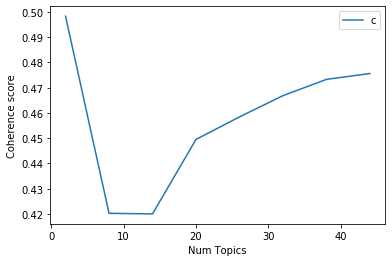

In [26]:
# Show graph
limit=50; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4983
Num Topics = 8  has Coherence Value of 0.4202
Num Topics = 14  has Coherence Value of 0.42
Num Topics = 20  has Coherence Value of 0.4495
Num Topics = 26  has Coherence Value of 0.4584
Num Topics = 32  has Coherence Value of 0.4669
Num Topics = 38  has Coherence Value of 0.4733
Num Topics = 44  has Coherence Value of 0.4756


In [28]:
lda_model = LdaModel(corpus=common_corpus_train,
                    id2word=common_dictionary,
                    num_topics= 38,
                    random_state=100,
                    update_every=1,
                    chunksize=100,
                    passes=20,
                    alpha=0.4,
                    eta=0.2,
                    per_word_topics=True)

In [29]:
print(lda_model.print_topics())

[(9, '0.098*"เค้า" + 0.086*"แบบนี้" + 0.069*"หรอ" + 0.035*"คนส่ง" + 0.022*"เท" + 0.018*"หนู" + 0.016*"ดาว" + 0.015*"ไหว้" + 0.012*"วน" + 0.012*"ดิ"'), (37, '0.136*"พี่" + 0.061*"นะคะ" + 0.051*"แมน" + 0.049*"ไลน์" + 0.038*"คน" + 0.028*"น่ารัก" + 0.028*"ขอบคุณ" + 0.026*"เหมือน" + 0.020*"ดีมาก" + 0.019*"ผม"'), (22, '0.149*"บาท" + 0.073*"สั่ง" + 0.073*"ค่าส่ง" + 0.067*"ลด" + 0.066*"โค้ด" + 0.061*"ส่วนลด" + 0.045*"ราคา" + 0.029*"ค่า" + 0.026*"ส่งฟรี" + 0.019*"ขั้นต่ำ"'), (7, '0.015*"ก้อน" + 0.010*"แซลมอน" + 0.009*"น้ำปลา" + 0.009*"ปัง" + 0.008*"นัว" + 0.006*"ซูชิ" + 0.005*"เบคอน" + 0.004*"ไม่งั้น" + 0.004*"คนเรา" + 0.004*"ตามใจ"'), (3, '0.093*"สั่ง" + 0.075*"ไม่ได้" + 0.073*"รอ" + 0.050*"คนขับ" + 0.048*"ยกเลิก" + 0.045*"ออเดอร์" + 0.042*"โทร" + 0.034*"ร้าน" + 0.027*"นาที" + 0.026*"บอ"'), (2, '0.082*"เจอ" + 0.049*"หน้า" + 0.041*"ขับ" + 0.022*"เด้อ" + 0.016*"ด่า" + 0.015*"ขี่" + 0.014*"ไปดู" + 0.012*"ที่จอดรถ" + 0.011*"ฝน" + 0.011*"หก"'), (1, '0.111*"แถม" + 0.046*"ชา" + 0.032*"แก้ว" + 0.032*"

In [30]:
def format_topics_sentences_old(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
       
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [31]:
common_corpus_test = [common_dictionary.doc2bow(text) for text in X_test]

In [32]:
df_dominant_topic = format_topics_sentences_old(ldamodel=lda_model, corpus=common_corpus_test, texts=X_test)

In [33]:
df_dominant_topic = df_dominant_topic.reset_index()

In [34]:
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text_preprocessed']

In [35]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text_preprocessed
0,0,37.0,0.1086,"พี่, นะคะ, แมน, ไลน์, คน, น่ารัก, ขอบคุณ, เหมื...","[พีค, สั่ง, ซื้อ, น้ำเปล่า, เข้ามา, ขี้เกียจ, ..."
1,1,3.0,0.1859,"สั่ง, ไม่ได้, รอ, คนขับ, ยกเลิก, ออเดอร์, โทร,...","[ออเดอร์, ลูกค้า, ซ้อน, หรอ, รู้, สั่ง, ชา, นม..."
2,2,22.0,0.1609,"บาท, สั่ง, ค่าส่ง, ลด, โค้ด, ส่วนลด, ราคา, ค่า...","[สั่ง, เค, ซี, ฟู้ด, ลด, โค้ด, ลด, ดือ, ออ]"
3,3,3.0,0.1375,"สั่ง, ไม่ได้, รอ, คนขับ, ยกเลิก, ออเดอร์, โทร,...","[ราเม็ง, ข้อสอบ, สั่ง, สะดวก, ดี, นาที, กิน]"
4,4,32.0,0.1177,"อาหาร, ติดต่อ, เบอร์, แอป, ทัก, สักพัก, รับผิด...","[ตู, โดน, ขโมย, เบอร์, นัง, ระบบ, รู้, โง่, ทอ..."
...,...,...,...,...,...
683,683,3.0,0.2820,"สั่ง, ไม่ได้, รอ, คนขับ, ยกเลิก, ออเดอร์, โทร,...","[อีกแล้ว, ฟู้ด, ไม่ได้อาหาร, อีกแล้ว, งง, จ่าย..."
684,684,37.0,0.1087,"พี่, นะคะ, แมน, ไลน์, คน, น่ารัก, ขอบคุณ, เหมื...","[เอ่อ, สภาพ, คน, กิน, ไหม, อะ]"
685,685,30.0,0.1417,"อะ, ซื้อ, จ่าย, เงินสด, ดีกว่า, คนเดียว, ตัวเอ...","[สั่งอาหาร, จ่าย, แบบนี้, ยอดเงิน, คงเหลือ, พอ..."
686,686,1.0,0.1600,"แถม, ชา, แก้ว, นม, น้า, โปร, ไข่มุก, เดือน, เว...","[อี, ผู้ประกอบการ, แถม, แอพ, เหมือน, อีแก, ฟู้..."


In [58]:
df_dominant_topic['Topic_Keywords'][0:2]

0    พี่, นะคะ, แมน, ไลน์, คน, น่ารัก, ขอบคุณ, เหมื...
1    สั่ง, ไม่ได้, รอ, คนขับ, ยกเลิก, ออเดอร์, โทร,...
Name: Topic_Keywords, dtype: object

## Word2Vec

In [36]:
model = Word2Vec(df['preprocessed'])

In [37]:
System_ = 'ปิด ปิดร้าน ชั่วคราว ระบบ ตัดเงิน ตัดบัตร เป็นอะไร พัง ค้าง ล่ม เสีย สั่งไม่ได้ เด้ง พัฒนา หักเงิน แอป แอพ ปัก ปักหมุด พิกัด ใช้ยาก ใช้ง่าย พัฒนา ไม่ตรง แผนที่'

In [38]:
System_Aspect = System_.split(' ')

In [39]:
Company_ = 'คอลเซนเตอร์ รับผิดชอบ เบอร์ ติดต่อ สื่อสาร โทร เมล ไม่ได้เงินคืน ร้องเรียน ไม่สนใจ เพิกเฉย รอสาย ตัดสาย บริการ ด่วน เมล โทร ศูนย์บริการ เจ้าหน้าที่ ปัญหา ชดเชย เลิกใช้ แบน บริษัท ตัดบัตร โกงเงิน บัญชี เลิกใช้ แคนเซิล สั่งทุกวัน ลบ รัก'

In [40]:
Company_Aspect = Company_.split(' ')

In [41]:
Price_ = 'ราคา ค่าส่ง ส่วนลด โปรโมชั่น คุ้มค่า ไม่คุ้ม แพง ถูก ลด โปร บอกต่อ คุ้ม ค่าบริการ ใช้ไม่ได้ ใช้งานไม่ได้ คุณภาพ ใช้ได้ ซื้อ ขั้นต่ำ ส่งฟรี แกง บาท ส่วนต่าง ลูกค้าใหม่ โค้ด เพิ่ม'

In [42]:
Price_Aspect = Price_.split(' ')

In [43]:
Employee_ = 'ยกเลิก รอ ช้า นาน ไม่ได้รับ ไม่ได้อาหาร ปัญหา รอเพิ่ม ผู้ส่ง พนักงาน คนขับ อบรม มารยาท คำพูด รอนาน บริการ นิสัย เละเทะ ไม่รับสาย ส่ง ไรเดอร์ เสีย คน ติดต่อ ไม่ครบ ขาด หาย ส่งช้า ไม่ครบ คนส่ง ไม่ครบ พนง สุภาพ นาที'

In [44]:
Employee_Aspect = Employee_.split(' ')

In [45]:
list_aspect = []
for term in df_dominant_topic['Topic_Keywords']: 
    likelihoods = []
    for aspect in [System_Aspect,Company_Aspect,Price_Aspect,Employee_Aspect]:
        likelihood = 0
        for word in term.split(', '):
            system_sim = [0]
            for keyword in aspect:
                try:
                    sim = model.wv.similarity(word, keyword)
                    system_sim.append(sim)
                except KeyError:
                    pass
            max_system_sim = max(system_sim)
            likelihood += max_system_sim
        likelihoods.append(likelihood)
    max_likelihoods = np.argmax(likelihoods)
    list_aspect.append(max_likelihoods)


In [46]:
result_predict_aspect = pd.DataFrame(y_test)

In [47]:
result_predict_aspect['Predicted'] = list_aspect

In [48]:
name_dict = {0:'System',1:'Company',2:'Price',3:'Employee'}

In [49]:
result_predict_aspect['Predicted_Aspect'] = result_predict_aspect['Predicted'].map(name_dict)

In [50]:
result_predict_aspect[['Topic','Keyword']] = df_dominant_topic[['Dominant_Topic','Topic_Keywords']]

In [51]:
result_predict_aspect

,tweet,Aspect,Predicted,Predicted_Aspect,Topic,Keyword
0,พีคสุดคือการสั่งให้ซื้อน้ำเปล่าเข้ามาให้เนี่ย\...,Employee,3,Employee,37.0,"พี่, นะคะ, แมน, ไลน์, คน, น่ารัก, ขอบคุณ, เหมื..."
1,#foodpanda รับออเดอร์ลูกค้าซ้อนกันได้ด้วยหรอค่...,Employee,3,Employee,3.0,"สั่ง, ไม่ได้, รอ, คนขับ, ยกเลิก, ออเดอร์, โทร,..."
2,สั่งเคฟซีจากฟู้ดแพนด้าลดจาก220 เหลือ149 ใช้โค้...,Price,2,Price,22.0,"บาท, สั่ง, ค่าส่ง, ลด, โค้ด, ส่วนลด, ราคา, ค่า..."
3,ราเม็งข้อสอบ .. ฟินนน... \nสั่ง GrabFood สะดว...,Company,3,Employee,3.0,"สั่ง, ไม่ได้, รอ, คนขับ, ยกเลิก, ออเดอร์, โทร,..."
4,ส่วนตูโดนขโมยเบอร์ไปใช้จ้า นังระบบ #foodpanda ...,Company,1,Company,32.0,"อาหาร, ติดต่อ, เบอร์, แอป, ทัก, สักพัก, รับผิด..."
...,...,...,...,...,...,...
683,อีกแล้วนะฟู้ดแพนด้า ไม่ได้อาหารอีกแล้ว แต่ขึ้น...,Company,3,Employee,3.0,"สั่ง, ไม่ได้, รอ, คนขับ, ยกเลิก, ออเดอร์, โทร,..."
684,เอ่อ สภาพนี่ให้คนกินไหมอะคะ #lineman pic.twit...,Employee,3,Employee,37.0,"พี่, นะคะ, แมน, ไลน์, คน, น่ารัก, ขอบคุณ, เหมื..."
685,จะสั่งอาหาร จ่ายผ่าน Grabpay มันเป็นแบบนี้ตั้ง...,System,1,Company,30.0,"อะ, ซื้อ, จ่าย, เงินสด, ดีกว่า, คนเดียว, ตัวเอ..."
686,อี #foodpanda ก็คือถูกกว่าจริง friendly กับผู้...,Company,2,Price,1.0,"แถม, ชา, แก้ว, นม, น้า, โปร, ไข่มุก, เดือน, เว..."


In [52]:
#accuracy of model
np.average(result_predict_aspect['Aspect'] == result_predict_aspect['Predicted_Aspect'])

0.5101744186046512

In [53]:
from sklearn import metrics

In [54]:
metrics.adjusted_rand_score(result_predict_aspect['Aspect'],result_predict_aspect['Predicted_Aspect'])

0.12195751651222349

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

In [56]:
print(classification_report(result_predict_aspect['Aspect'],result_predict_aspect['Predicted_Aspect']))

              precision    recall  f1-score   support

     Company       0.20      0.09      0.13       110
    Employee       0.43      0.78      0.55       224
       Price       0.79      0.60      0.68       248
      System       0.42      0.17      0.24       106

    accuracy                           0.51       688
   macro avg       0.46      0.41      0.40       688
weighted avg       0.52      0.51      0.48       688

